In [39]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile,join
from time import sleep
def P2dB(P): return 10*np.log10(np.abs(P))

In [40]:
fpath='xst_test3_mean'
files=listdir(fpath)#[f for f in listdir(fpath)];
files.sort()
files = [f for f in files if isfile(join(fpath,f))]
print(len(files))
print(files)

1
['xst_mean_2022-07-07-10.npz']


In [41]:
D=[]
Cnt=[]
dates=[]
for fn in files:
    D2=np.load(fpath+"/"+fn)
    D.append(D2['xst'])
    Cnt.append(D2['cnt'])
    dates.append(fn.split('.')[0][9:])
D=np.array(D)
Cnt=np.array(Cnt)
print(D.shape,Cnt.shape)
print(Cnt[:,10])

(1, 512, 18, 18) (1, 512)
[40]


In [42]:
print(dates)

['2022-07-07-10']


[0]


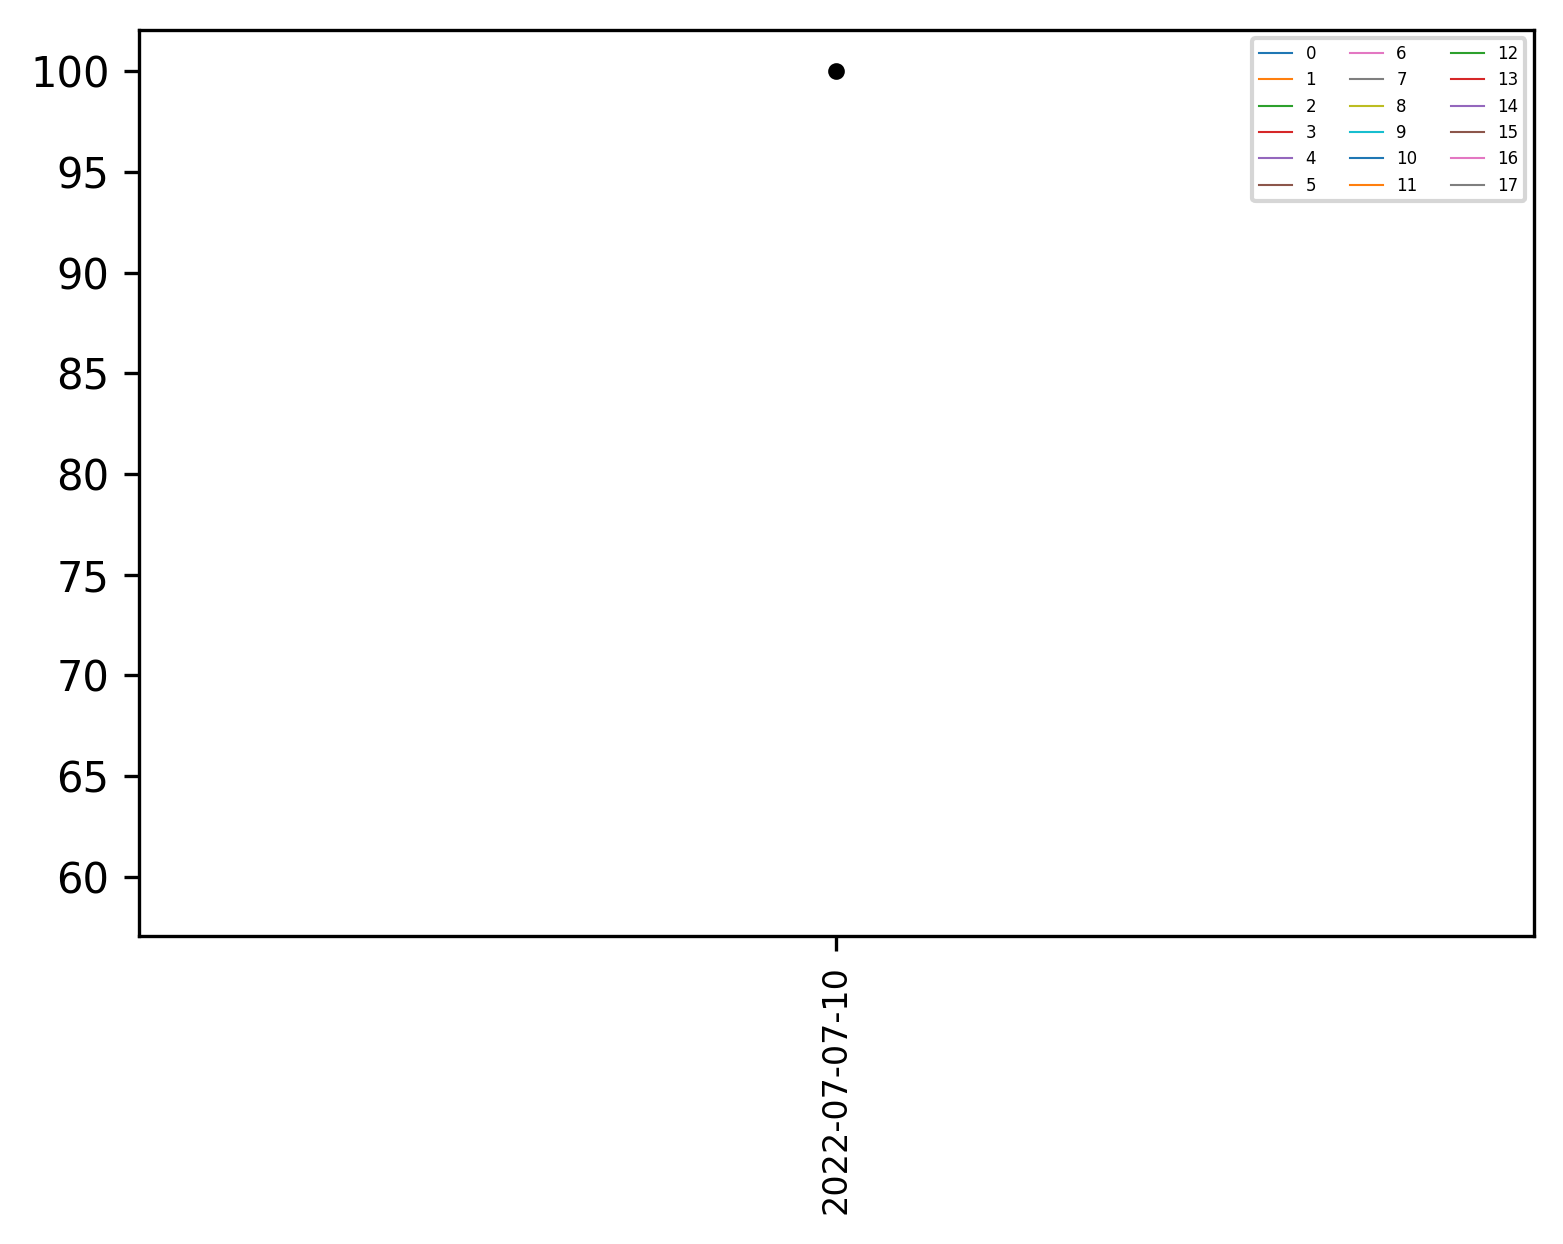

In [43]:
plt.figure(dpi=300)
x1=0
x2=-1
#x1=19
#x2=21
for i in range(18):
    plt.plot(dates[:],P2dB(np.sum(D[:,7:,i,i]*Cnt[:,7:],axis=1)/np.sum(Cnt[:,7:],axis=1)),'-',label='%i'%i,linewidth=0.5)
#mask=P2dB(np.sum(D[:,:,0,0],axis=1))
mask=P2dB(np.sum(D[:,7:,i,i]*Cnt[:,7:],axis=1)/np.sum(Cnt[:,7:],axis=1))
#mask=np.array([np.isreal(x)*(x>90)*(x<92)*1 for x in mask])
mask=np.array([np.isreal(x)*1 for x in mask])
#mask[-1]=0
plt.plot(dates[:],100/mask,'k.')
tms=np.arange(len(mask),dtype=int).compress(mask)
print(tms)
plt.legend(ncol=3,fontsize=4)
locs, labels = plt.xticks()
plt.xticks(locs[::],rotation=90,fontsize=8);

In [44]:
D2=np.sum(D[tms,:]*Cnt[tms,:,np.newaxis,np.newaxis],axis=0)/np.sum(Cnt[tms,:],axis=0)[:,np.newaxis,np.newaxis]

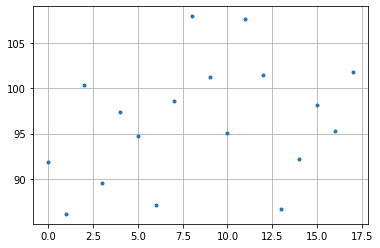

In [45]:
pwr=[P2dB(np.sum(D2[:,i,i])+1) for i in range(18)]
plt.plot(pwr,'.')
plt.grid()

In [46]:
sis=np.array(range(len(pwr)))
sis=sis.compress((np.array(pwr)>10)*(np.array(pwr)<120))
sis=np.array([0,1,2,3,4,5]) #Antenna 1,2,3,4 and 9 has terminators
print(sis)

[0 1 2 3 4 5]


In [47]:
#sis=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
pairs=[[x,y] for i,x in enumerate(sis) for y in sis[i+1:]]
#pairs=[[x,y] for i,x in enumerate(sis) for y in sis[i+1:i+2]]
print(pairs)


[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]


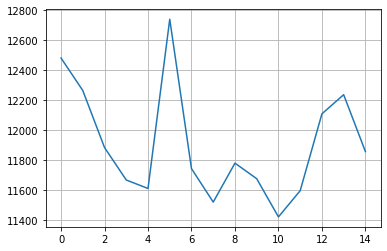

In [48]:
PPwr=[np.sum(P2dB(np.roll(D2[:,p[1],p[0]],-7)+1e-6)[1:]) for p in pairs]
plt.plot(PPwr)
Pcut=16000
plt.grid()
#plt.ylim(5000,8000)

No handles with labels found to put in legend.


Text(0.5, 0, 'Frequency (MHz)')

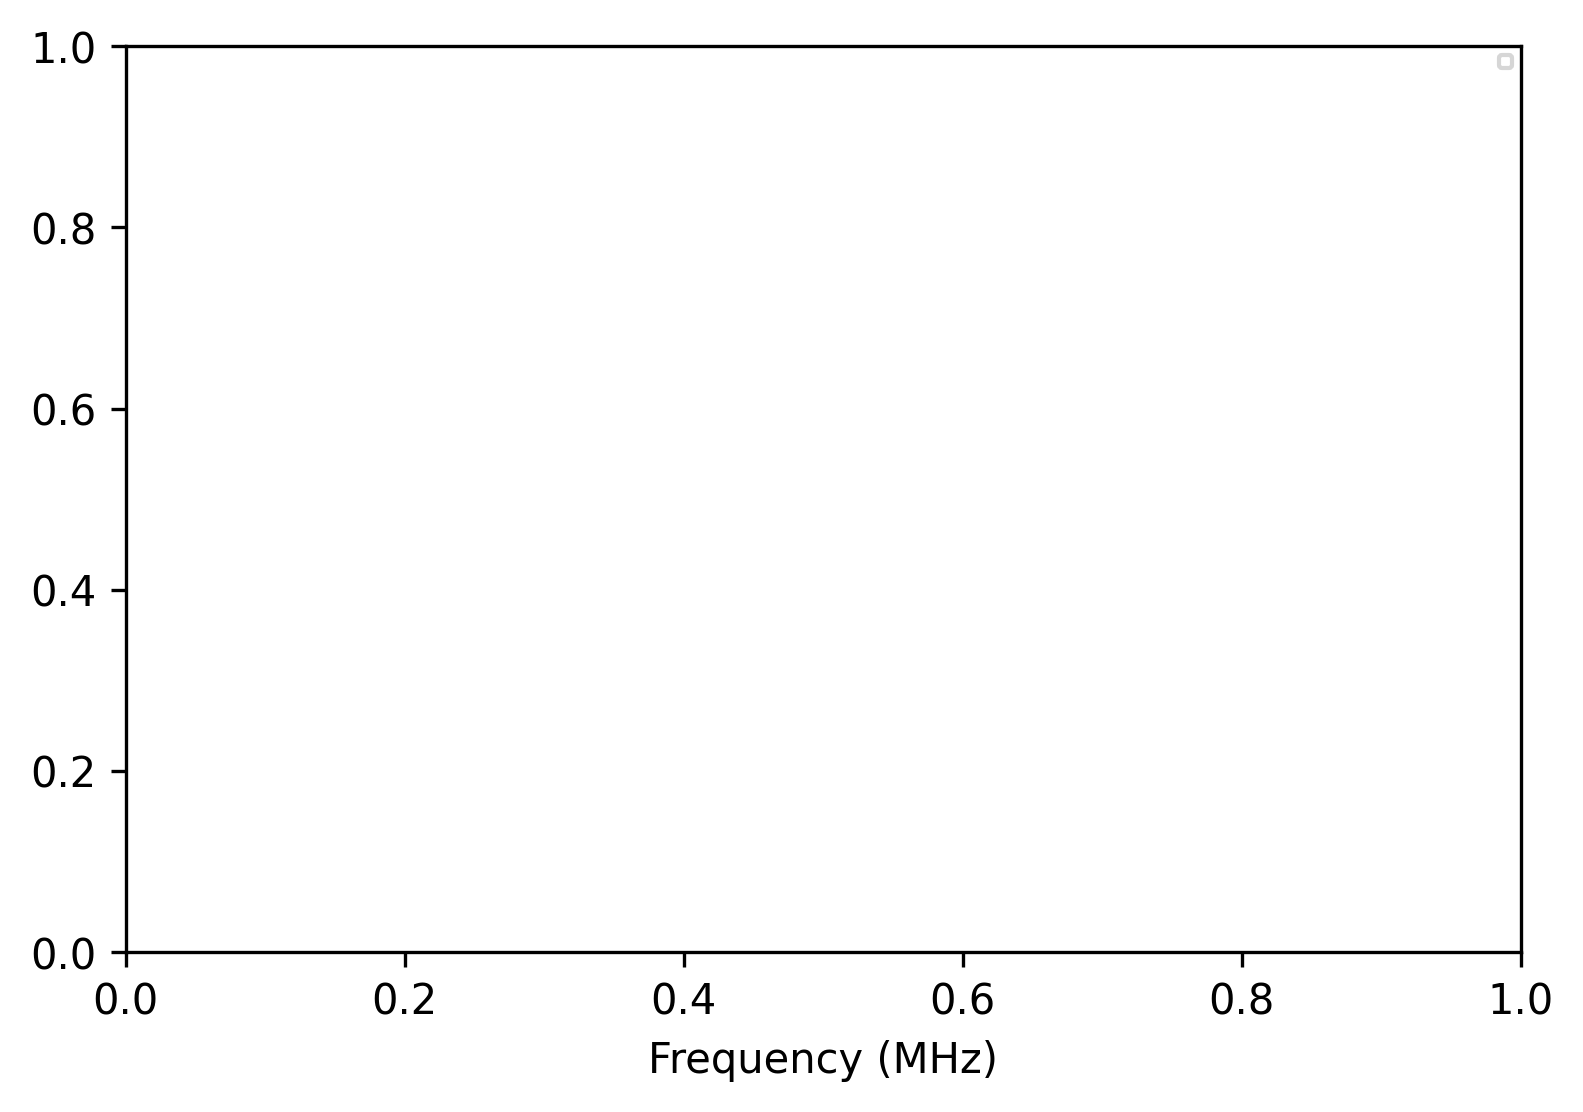

In [49]:
freq=np.arange(512)/512*100
plt.figure(dpi=300)
for i,[p1,p2] in enumerate(pairs):
    if PPwr[i]<Pcut: continue;
    plt.plot(freq[1:],P2dB(np.roll(D2[:,p2,p1],-7)+1e-6)[1:],label='%i-%i'%(p1,p2),linewidth=0.05)
#    plt.plot(freq[1:],np.angle(np.roll(D2[:,p2,p1],-6))[1:],label='%i-%i'%(p1,p2),linewidth=0.05)
plt.legend(fontsize=4,ncol=5)
#plt.ylim(0,60)
plt.xlabel("Frequency (MHz)")

In [50]:
cntmean=(np.mean(np.sum(Cnt,axis=0)))
print(P2dB(cntmean**2))

32.32532452432486


Text(0.5, 1.0, 'RCU2L-QM in DTS outside: Correlation between \npairs of channels. LBA off')

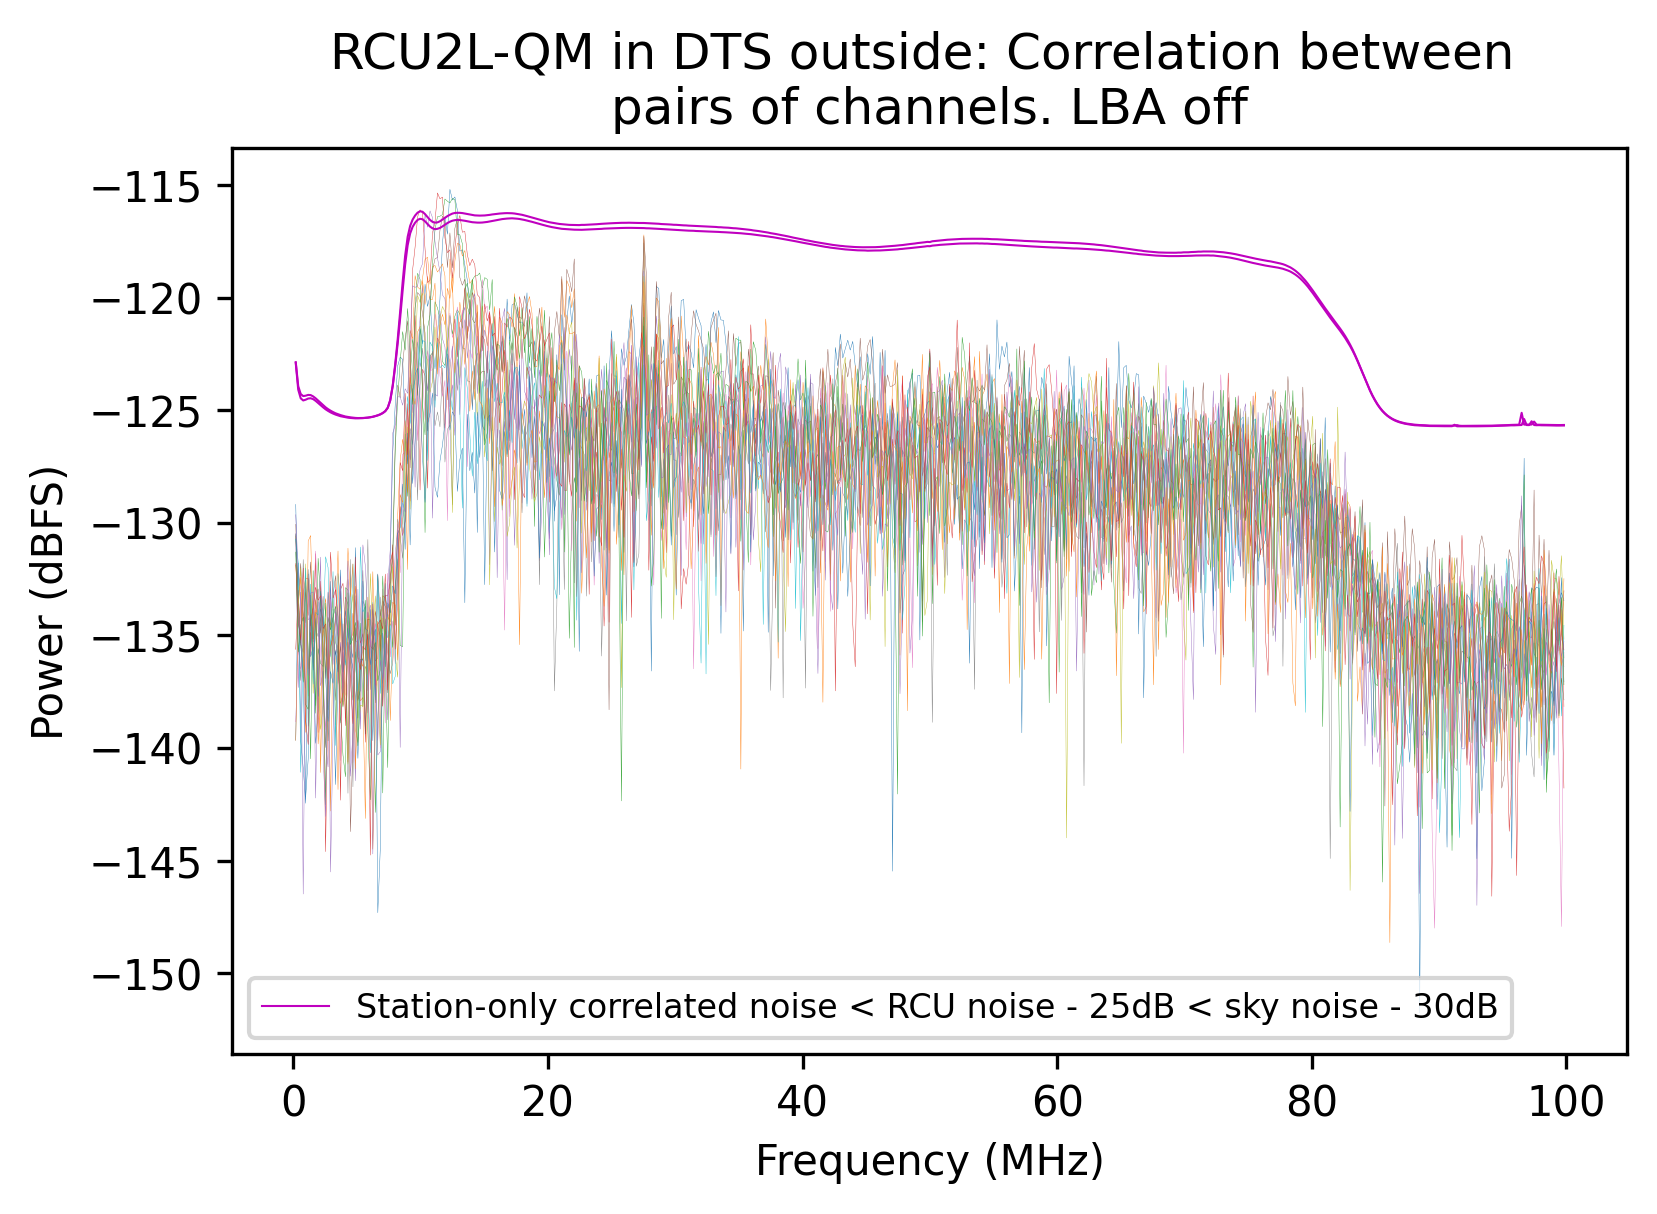

In [51]:
freq=np.arange(512)/512*100
plt.figure(dpi=300)
P1=np.zeros_like(freq[1:],dtype='float')
P2=np.zeros_like(freq[1:],dtype='complex')
GainADC=(10*np.log10(100e6)+20*np.log10(2**12)) #XST to dBFS

cnt=0;
for i,[p1,p2] in enumerate(pairs):
    if PPwr[i]>Pcut: continue;
    P1+=np.abs(np.roll(D2[:,p2,p1],-7)[1:])
    P2+=(np.roll(D2[:,p2,p1],-7)[1:])
    cnt+=1
    plt.plot(freq[1:],P2dB(np.roll(D2[:,p2,p1],-7)+1e-6)[1:]-GainADC,linewidth=0.1)
for i in sis[4:]:
    plt.plot(freq[1:],P2dB(np.roll(D2[:,i,i],-7))[1:]-30+5-GainADC,'m-',linewidth=0.5,label=('Station-only correlated noise < RCU noise - 25dB < sky noise - 30dB' if i==4 else ''))
#plt.plot(freq[1:],P2dB(P2/np.sqrt(cnt))-GainADC,'r-',linewidth=0.5,label='avg pwr')
#plt.plot(freq[1:],P2dB(P1/(cnt))-GainADC,'k-',linewidth=0.5,label='avg correlation')
plt.legend(fontsize=8,ncol=1)
#plt.ylim(0,30)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBFS)")
plt.title("RCU2L-QM in DTS outside: Correlation between \npairs of channels. LBA off")

Text(0.5, 0, 'Frequency (MHz)')

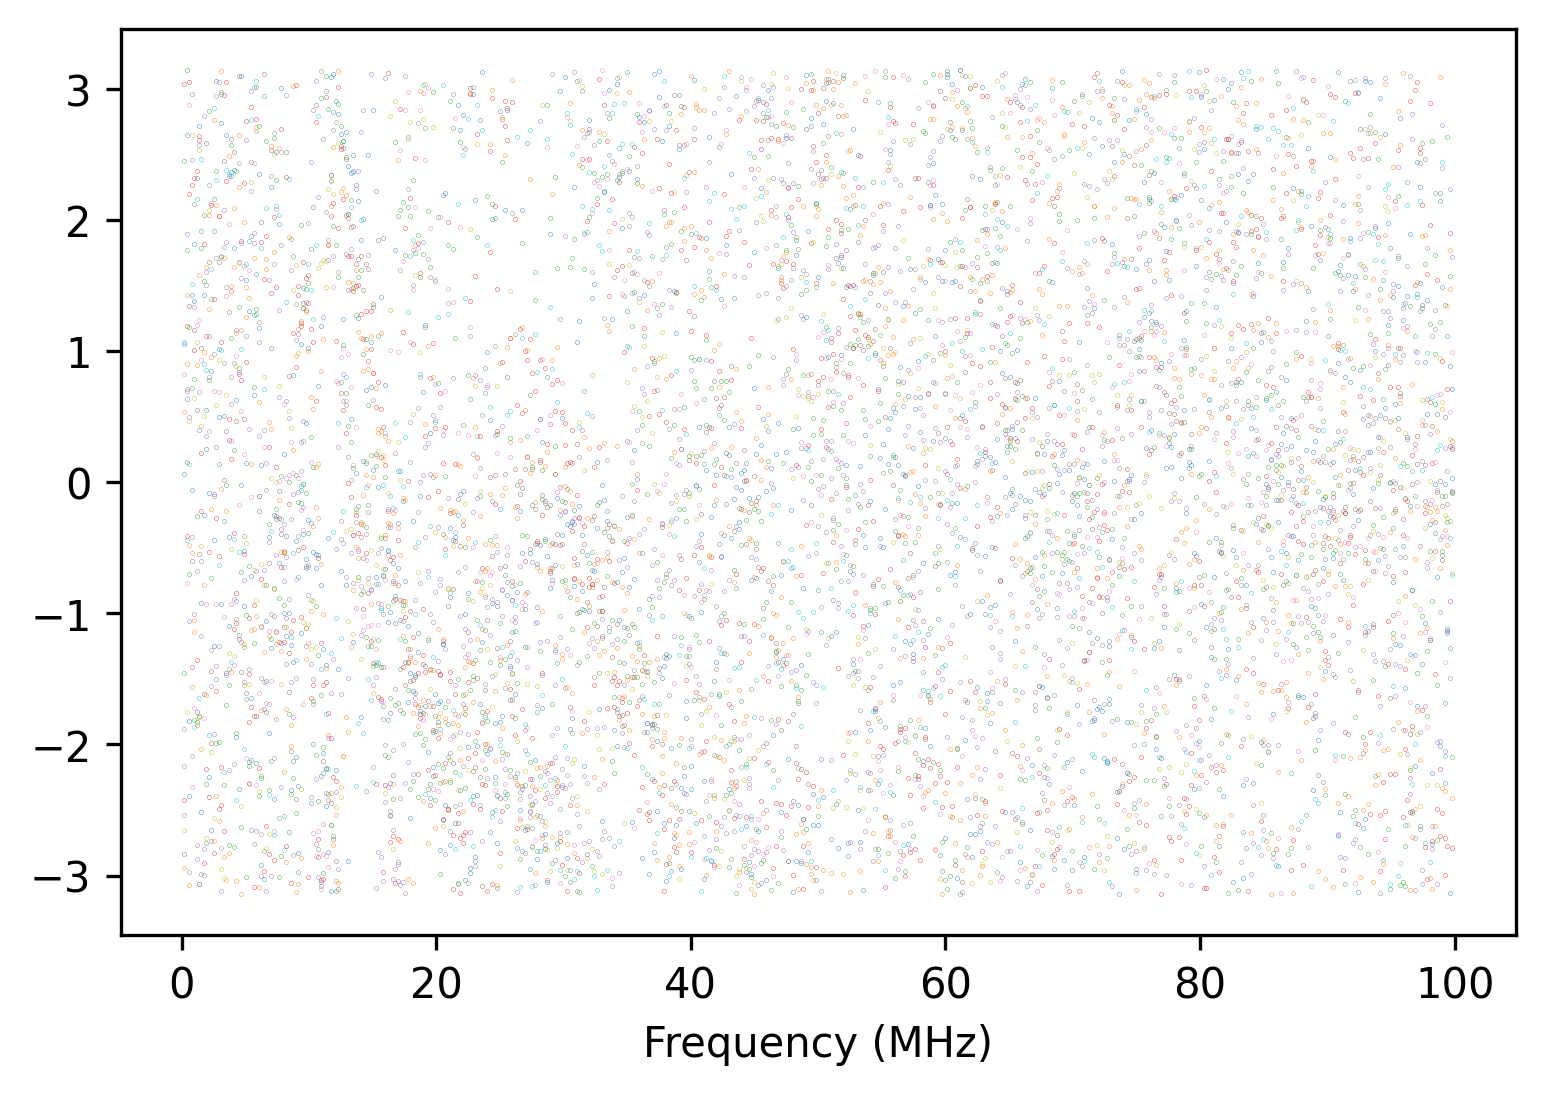

In [52]:
freq=np.arange(512)/512*100
plt.figure(dpi=300)
for i,[p1,p2] in enumerate(pairs):
    if PPwr[i]>Pcut: continue;
    plt.plot(freq[1:],np.angle(np.roll(D2[:,p2,p1],-7)+1e-6)[1:],'.',markersize=0.2,label='%i-%i'%(p1,p2),linewidth=0.05)
#plt.legend(fontsize=4,ncol=5)
#plt.ylim(0,60)
plt.xlabel("Frequency (MHz)")